#Face Verification

##Flowchart

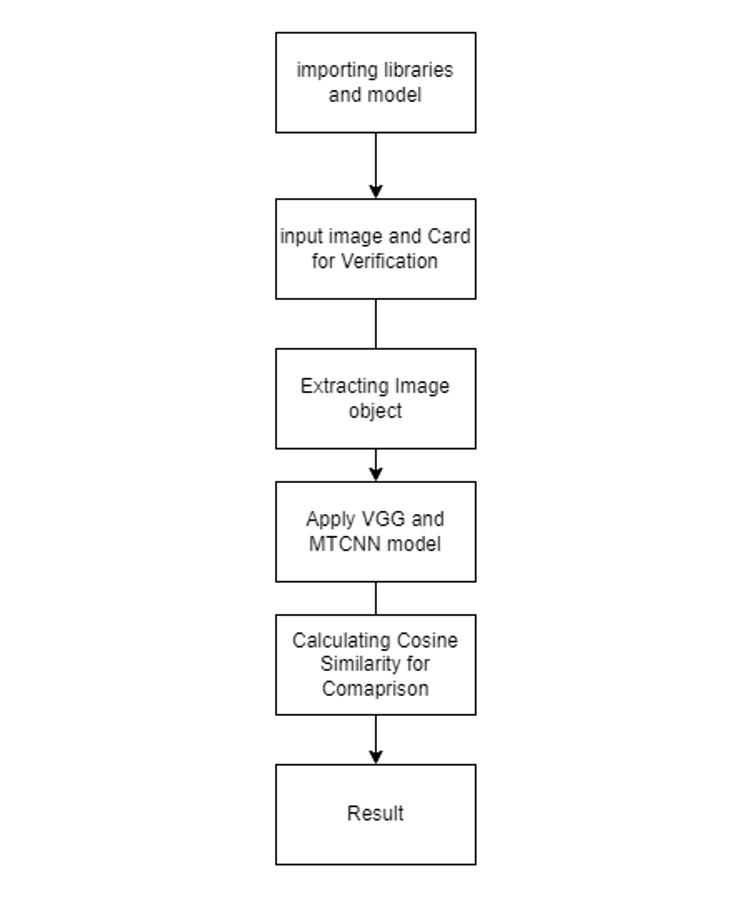

In [43]:
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_applications --no-deps
filename = "/usr/local/lib/python3.7/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))
import tensorflow as tf

from keras_vggface.vggface import VGGFace

vggface = VGGFace(model='resnet50') # or VGGFace() as default

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-rjengp47
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-rjengp47
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
import cv2
import numpy as np
from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace
from scipy.spatial.distance import cosine

import warnings
warnings.filterwarnings("ignore",category=FutureWarning)

In [45]:
image = cv2.imread('/content/DL.jpg')

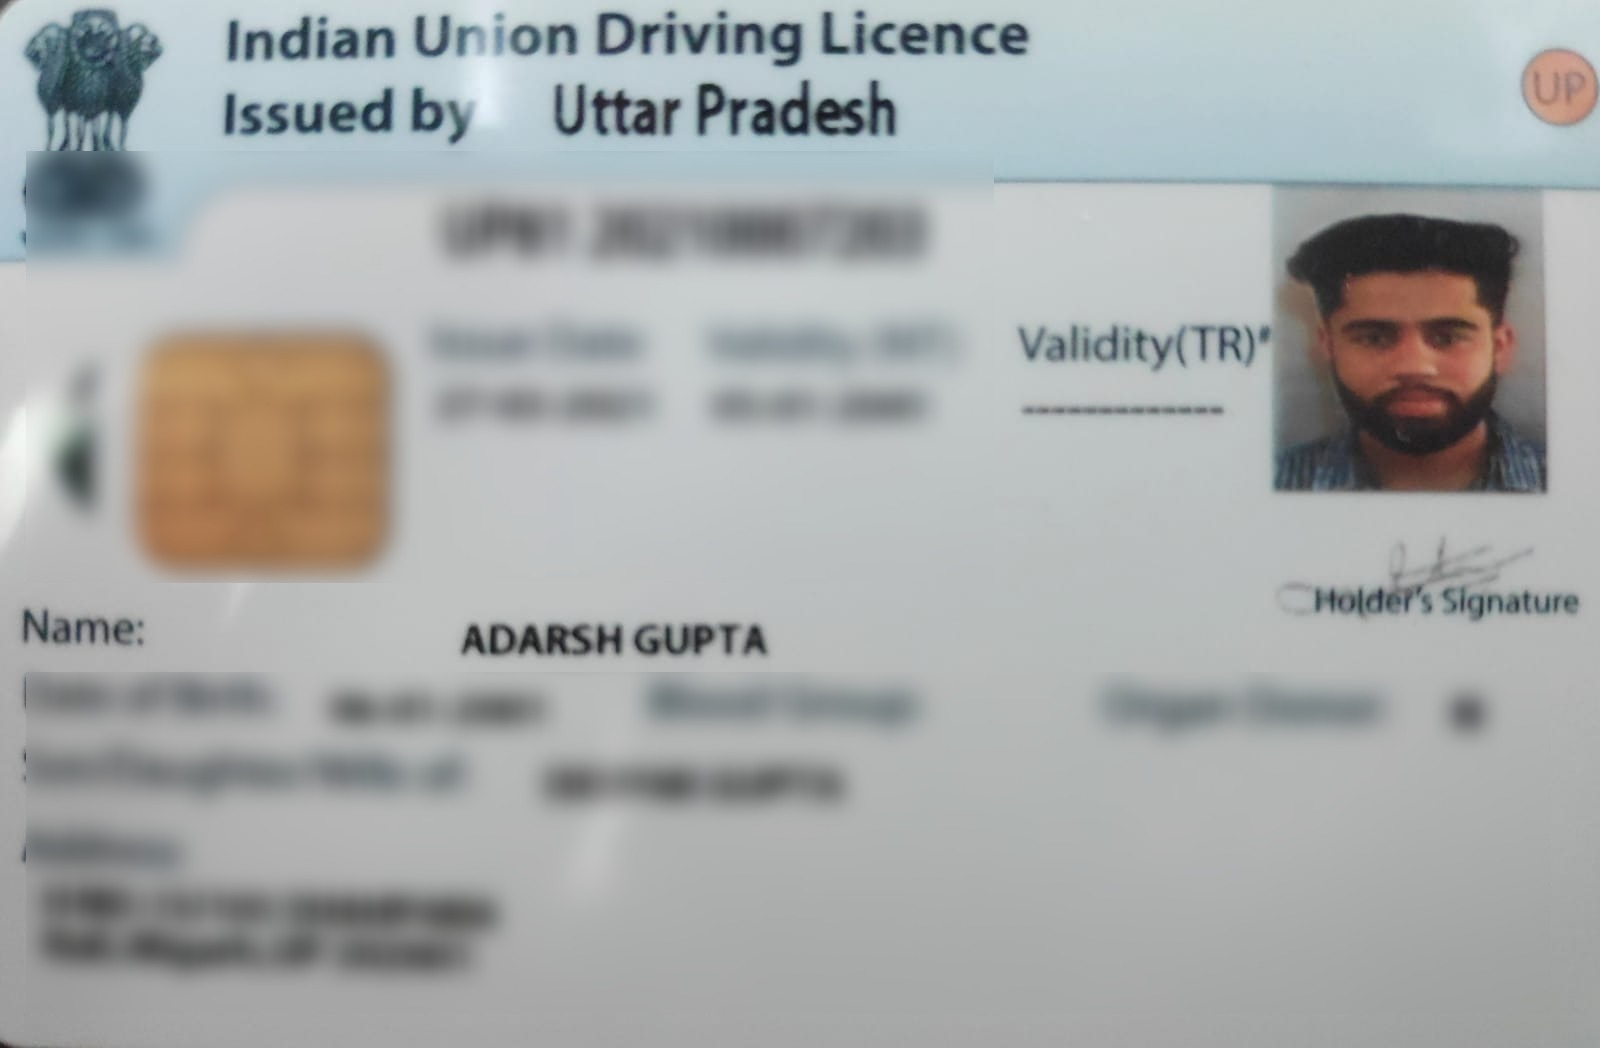

In [46]:
from google.colab.patches import cv2_imshow
cv2_imshow(image)

In [47]:
image1 = cv2.imread('/content/selfie1.jpg')
width = 250
height = 350
dim = (width, height)
 
# resize image
resized_selfie = cv2.resize(image1, dim, interpolation = cv2.INTER_AREA)

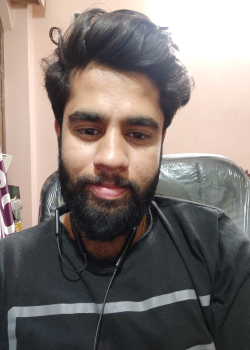

In [48]:
from google.colab.patches import cv2_imshow
cv2_imshow(resized_selfie)

In [49]:
img = cv2.imread('/content/fakeSelfie1.jpg')
width = 250
height = 350
dim = (width, height)
 
# resize image
resized_fakeSelfie = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

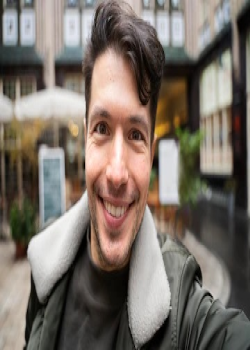

In [50]:
from google.colab.patches import cv2_imshow
cv2_imshow(resized_fakeSelfie)

#MTCNN
Multi-task Cascaded Convolutional Networks (MTCNN) is a framework developed as a solution for both face detection and face alignment. The process consists of three stages of convolutional networks that are able to recognize faces and landmark location such as eyes, nose, and mouth.

In [51]:
!pip install mtcnn
from mtcnn.mtcnn import MTCNN

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
# for extracting the face from a image we use mtcnn package
# also we are extracting the coordintes, confidence, keypoints of a image.

detector = MTCNN()

faces = detector.detect_faces(image)
for face in faces:
    print(face)

{'box': [1322, 269, 158, 182], 'confidence': 0.9928774237632751, 'keypoints': {'left_eye': (1376, 335), 'right_eye': (1451, 334), 'nose': (1422, 371), 'mouth_left': (1387, 410), 'mouth_right': (1449, 408)}}


In [53]:
# here defining the function with dimensions for creating the bounding box. 

def create_bbox(image):
  faces = detector.detect_faces(image)
  bounding_box = faces[0]['box']
  keypoints = faces[0]['keypoints']

  cv2.rectangle(image,
              (bounding_box[0], bounding_box[1]),
              (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
              (0,155,255),
              2)

  cv2.circle(image,(keypoints['left_eye']), 2, (0,155,255), 2)
  cv2.circle(image,(keypoints['right_eye']), 2, (0,155,255), 2)
  cv2.circle(image,(keypoints['nose']), 2, (0,155,255), 2)
  cv2.circle(image,(keypoints['mouth_left']), 2, (0,155,255), 2)
  cv2.circle(image,(keypoints['mouth_right']), 2, (0,155,255), 2)

  return image

In [54]:
marked_image = create_bbox(image)

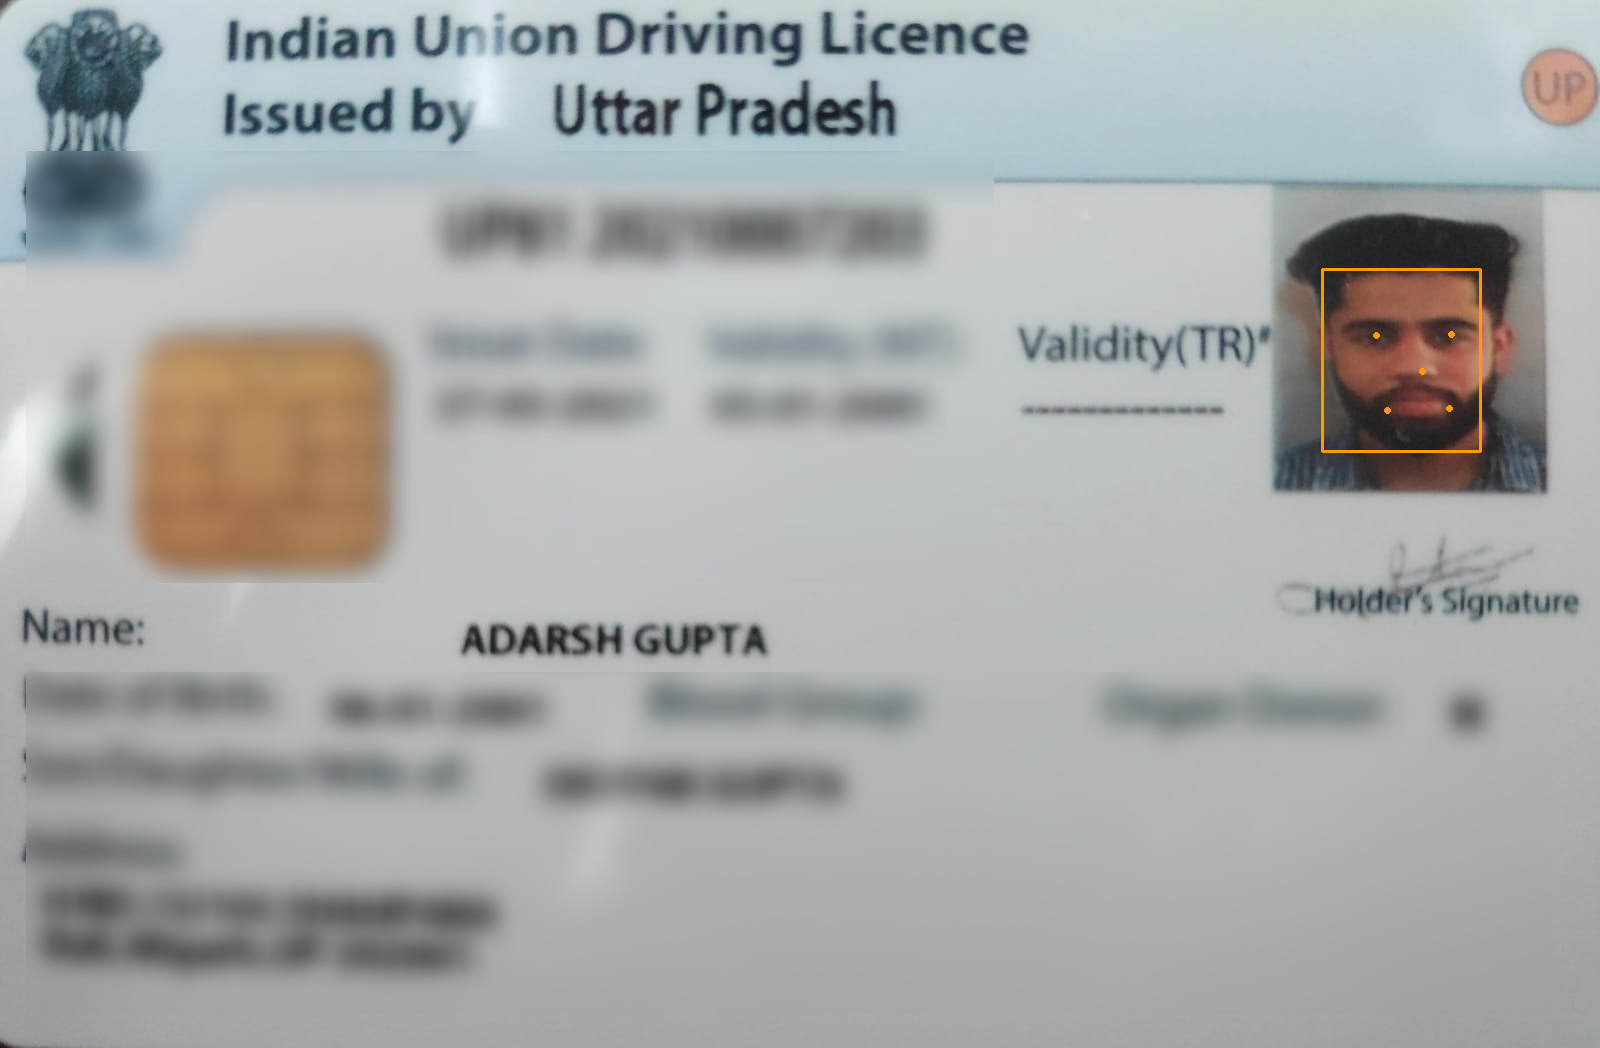

In [55]:
# Displaying the detected image with a bouding box 

cv2_imshow(marked_image)

In [56]:
# since now we know the exact location for face verification
# we will extract the image for this we have defined a fucntion 

def extract_face(image, resize=(224,224)):
  
  # here we have passed size as (244,244) as VGG model is trained on images for same size.
  image=cv2.imread(image)

  faces = detector.detect_faces(image)
  x1, y1, width, height = faces[0]['box']
  x2, y2, = x1 + width, y1 + height

  face_boundary = image[y1:y2, x1:x2]

  face_image=cv2.resize(face_boundary, resize)

  return face_image

###Displaying the Extracted Face Boundary

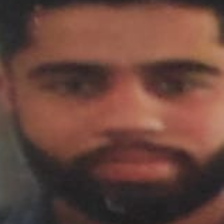

In [57]:
# displaying the extracted image object from a DL

face_image = extract_face('/content/DL.jpg')
cv2_imshow(face_image)

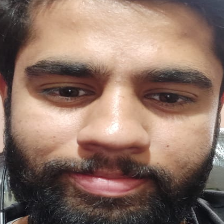

In [58]:
# displaying the extracted selfie image object from a selfie

face_selfie1 = extract_face('/content/selfie1.jpg')
cv2_imshow(face_selfie1)

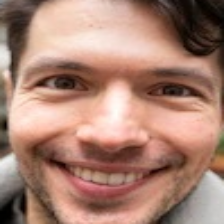

In [59]:
# displaying the extracted Fake selfie image object

face_selfie1 = extract_face('/content/fakeSelfie1.jpg')
cv2_imshow(face_selfie1)

#VGG Models
VGG models are a type of CNN Architecture proposed by Karen Simonyan & Andrew Zisserman of Visual Geometry Group (VGG), Oxford University, which brought remarkable results for the ImageNet Challenge.

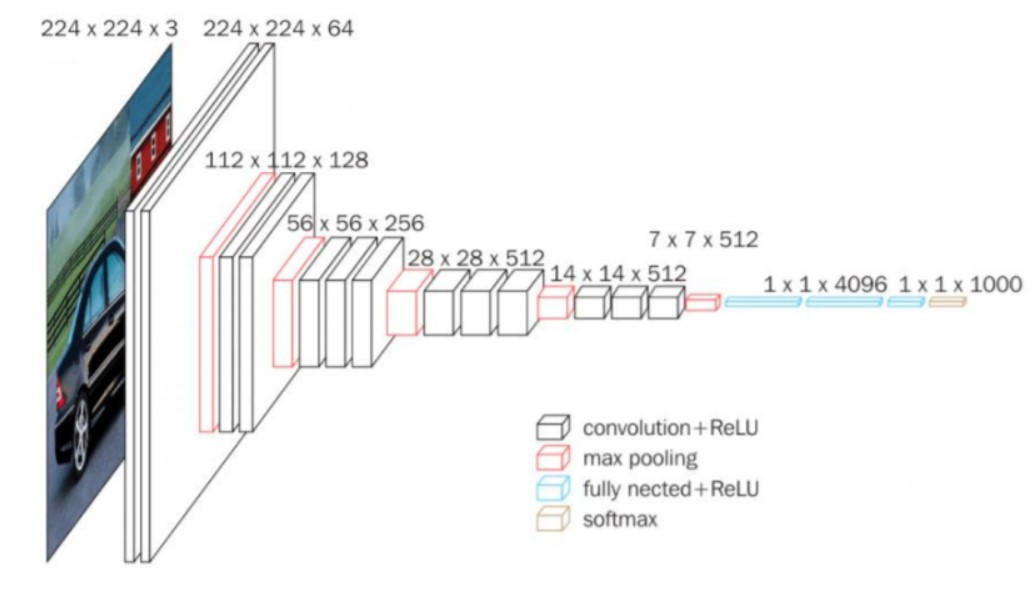


In [60]:
# extracting face embeddings by passing VGG Model
# VGG model is trained on approx 3.3 million faces already so it generalizes well on unseen faces
# here output will be of array of embeddings vector

def get_embeddings(faces):
  face = np.asarray(faces, 'float32')

  face = preprocess_input(face, version=2)

  model = VGGFace(model='resnet50', include_top=False, input_shape=(224,224,3), pooling ='avg')
  # The input to the convolution neural network is a fixed-size 224 × 224 RGB image.
  # here we use avg pooling for avg_filter


  return  model.predict(face)

#Cosine Similarity
I stumbled upon a similarity measurement called **Cosine Similarity**. I was intrigued by the simplicity of this implementation.

**Cosine Similarity is a measurement that quantifies the similarity between two or more vectors.**, it is a metric, helpful in determining, how similar the data objects are irrespective of their size. 


In [61]:
# to get the similarity between two faces by comparing both faces embiddings
# here we have used the "co-sine" as a metric to measure the score of our model 

def get_similarity(faces):
  embeddings = get_embeddings(faces)

  score = cosine(embeddings[0], embeddings[1])
  # print(embeddings[0])   // if we want to print the embedding array of a image.
  # print(embeddings[1])

  if score <= 0.5:
    return "Face Matched", score

  return "Face Not Matched", score

  # here we have defined the threshold value for a score.


In [62]:
# it will create list of faces for comparison purpose

faces = [extract_face(image) for image in ["/content/selfie1.jpg", "/content/DL.jpg"]]

In [63]:
faces1 = [extract_face(image) for image in ["/content/fakeSelfie1.jpg", "/content/DL.jpg"]]

#Result

If both the embeddings vector are closer then the output will be closer to zero, if both the embeddings vector are kind of not alike then the final cosine distance will be higher.
So, The closer it is to zero its going to be a match, the more it is closer to 1 it is not going to be match.

In [64]:
get_similarity(faces)

('Face Matched', 0.34210872650146484)

In [65]:
get_similarity(faces1)

('Face Not Matched', 0.7701795399188995)